# Installs & Imports

In [1]:
!pip install -q torch torchvision

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

# Data Loading

In [3]:
def load_mnist_data():
    """
    Load the MNIST training set for later splitting into train and test data.
    """
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    return dataset

In [4]:
# Load the data
mnist_dataset = load_mnist_data()

# Data Preparation

In [5]:
def split_dataset(dataset, train_ratio=0.8):
    """
    Split the dataset into training and testing subsets using the specified ratio.
    """
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    return random_split(dataset, [train_size, test_size])

In [6]:
# Split the full dataset into 80% train and 20% test
train_dataset, test_dataset = split_dataset(mnist_dataset)

In [7]:
# Print shapes
print("Train dataset shape:", len(train_dataset))
print("Test dataset shape:", len(test_dataset))

Train dataset shape: 48000
Test dataset shape: 12000


In [8]:
def prepare_data(dataset, flatten=True):
    """
    Prepare data from the given dataset and return numpy arrays for inputs and labels.
    If flatten is True, images are reshaped to vectors; otherwise the original image shape is kept.
    """
    X, y = [], []
    for img, label in dataset:
        if flatten:
            X.append(img.view(-1).numpy())
        else:
            X.append(img.numpy())
        y.append(label)
    return np.array(X), np.array(y)

In [9]:
# Prepare flattened data for DBN and ELM
X_train_flat, y_train_flat = prepare_data(train_dataset, flatten=True)
X_test_flat, y_test_flat = prepare_data(test_dataset, flatten=True)

In [10]:
# Prepare image data for CNN (original shape, e.g. 28x28)
X_train_img, y_train_img = prepare_data(train_dataset, flatten=False)
X_test_img, y_test_img = prepare_data(test_dataset, flatten=False)

In [11]:
def apply_pca(X_train, X_test, n_components=100):
    """
    Apply PCA to the training data and transform the test data accordingly.
    """
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

In [12]:
# Apply PCA for dimensionality reduction for MLP only (from flattened data)
X_train_pca, X_test_pca, pca_model = apply_pca(X_train_flat, X_test_flat, n_components=100)

# Model Definition

In [13]:
# --- RBM for DBN pretraining ---
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        """
        Initialize the RBM with the given visible and hidden dimensions.
        """
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        # Initialize weight matrix and biases
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        # Initialize momentum buffers
        self.W_mom = torch.zeros_like(self.W)
        self.h_bias_mom = torch.zeros_like(self.h_bias)
        self.v_bias_mom = torch.zeros_like(self.v_bias)

    def sample_h(self, v):
        """
        Compute hidden unit probabilities and sample hidden activations.
        """
        activation = torch.matmul(v, self.W.t()) + self.h_bias
        p_h = torch.sigmoid(activation)
        return p_h, torch.bernoulli(p_h)

    def sample_v(self, h):
        """
        Compute visible unit probabilities and sample visible activations.
        """
        activation = torch.matmul(h, self.W) + self.v_bias
        p_v = torch.sigmoid(activation)
        return p_v, torch.bernoulli(p_v)

    def contrastive_divergence(self, v0, k=1):
        """
        Run k steps of Gibbs sampling starting from v0.
        """
        v = v0
        for _ in range(k):
            p_h, h = self.sample_h(v)
            p_v, v = self.sample_v(h)
        return v

In [14]:
# DBN classifier that stacks two pretrained RBM layers and a final output layer
class DBNClassifier(nn.Module):
    def __init__(self, n_visible, n_hidden1, n_hidden2, n_classes):
        """
        Initialize the DBN classifier with two hidden layers and an output layer.
        """
        super(DBNClassifier, self).__init__()
        self.fc1 = nn.Linear(n_visible, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Define the forward pass of the DBN classifier.
        """
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
# --- Extreme Learning Machine (ELM) ---
class ELM(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        """
        Initialize the ELM with fixed random hidden weights and a trainable output layer.
        """
        super(ELM, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        # Random, fixed weights for the hidden layer
        self.input_weights = nn.Parameter(torch.randn(n_hidden, n_input), requires_grad=False)
        self.bias = nn.Parameter(torch.randn(n_hidden), requires_grad=False)
        self.output_layer = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        """
        Define the forward pass of the ELM.
        """
        hidden = torch.sigmoid(torch.matmul(x, self.input_weights.t()) + self.bias)
        out = self.output_layer(hidden)
        return out

In [16]:
# --- Multi-Layer Perceptron (MLP) ---
class MLP(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        """
        Initialize the MLP with one hidden layer.
        """
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

    def forward(self, x):
        """
        Define the forward pass of the MLP.
        """
        return self.model(x)

In [17]:
# --- Convolutional Neural Network (CNN) ---
class CNN(nn.Module):
    def __init__(self, n_classes=10):
        """
        Initialize the CNN for image data (original MNIST images).
        """
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14 -> 7x7
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        """
        Define the forward pass of the CNN.
        """
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Model Training

In [18]:
def train_rbm(
    rbm,
    data_loader,
    lr=0.01,
    k=1,
    epochs=5,
    momentum=0.5,
    weight_decay=0.0002
):
    """
    Train the given RBM using Contrastive Divergence with momentum and weight decay.
    """
    rbm.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch, _ in data_loader:
            # Flatten batch and binarize input (MNIST pixels are in [0,1])
            v0 = batch.view(-1, rbm.n_visible)
            v0 = torch.bernoulli(v0)

            # Positive phase
            p_h0, h0 = rbm.sample_h(v0)
            positive_grad = torch.matmul(p_h0.t(), v0)

            # Negative phase via k-step Gibbs sampling
            v_k = v0
            for _ in range(k):
                p_hk, h_k = rbm.sample_h(v_k)
                p_vk, v_k = rbm.sample_v(h_k)
            p_hk, _ = rbm.sample_h(v_k)
            negative_grad = torch.matmul(p_hk.t(), v_k)

            # Compute gradients
            grad_W = (positive_grad - negative_grad) / v0.size(0) - weight_decay * rbm.W
            grad_v_bias = torch.mean(v0 - v_k, dim=0)
            grad_h_bias = torch.mean(p_h0 - p_hk, dim=0)

            # Update momentum buffers
            rbm.W_mom = momentum * rbm.W_mom + lr * grad_W
            rbm.v_bias_mom = momentum * rbm.v_bias_mom + lr * grad_v_bias
            rbm.h_bias_mom = momentum * rbm.h_bias_mom + lr * grad_h_bias

            # Update parameters
            rbm.W.data += rbm.W_mom
            rbm.v_bias.data += rbm.v_bias_mom
            rbm.h_bias.data += rbm.h_bias_mom

            # Compute reconstruction loss (mean squared error)
            loss = torch.mean((v0 - v_k) ** 2)
            epoch_loss += loss.item()
        print(f"RBM Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(data_loader):.4f}")

In [19]:
def pretrain_dbn(
    train_loader,
    n_visible=784,
    n_hidden1=256,
    n_hidden2=128,
    rbm_epochs=5,
    lr=0.01,
    k=1,
    momentum=0.5,
    weight_decay=0.0002
):
    """
    Pretrain two RBM layers and return the pretrained RBMs.
    """
    # Pretrain first RBM on raw flattened data (dimension 784)
    rbm1 = RBM(n_visible, n_hidden1)
    print("Pretraining RBM 1...")
    train_rbm(rbm1, train_loader, lr=lr, k=k, epochs=rbm_epochs, momentum=momentum, weight_decay=weight_decay)

    # Transform data through RBM1 for second-layer training
    def transform(loader, rbm):
        transformed = []
        for batch, _ in loader:
            v = batch.view(-1, rbm.n_visible)
            with torch.no_grad():
                p_h, _ = rbm.sample_h(v)
            transformed.append(p_h)
        return torch.cat(transformed, dim=0)

    train_features_rbm1 = transform(train_loader, rbm1)
    dataset_features = TensorDataset(train_features_rbm1, torch.zeros(train_features_rbm1.size(0)))
    loader_features = DataLoader(dataset_features, batch_size=64, shuffle=True)

    # Pretrain second RBM on features from RBM1
    rbm2 = RBM(n_hidden1, n_hidden2)
    print("\nPretraining RBM 2...")
    train_rbm(rbm2, loader_features, lr=lr, k=k, epochs=rbm_epochs, momentum=momentum, weight_decay=weight_decay)

    return rbm1, rbm2

In [20]:
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    """
    Generic training loop for supervised models.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {total_loss/len(train_loader):.4f}")

In [21]:
def predict_model(model, data_loader):
    """
    Return a numpy array of predictions for the given model and data loader.
    """
    model.eval()
    preds = []
    with torch.no_grad():
        for batch, _ in data_loader:
            outputs = model(batch)
            predicted = torch.argmax(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())
    return np.array(preds)

In [22]:
# For DBN and ELM, use the flattened data as is (dimension 784)
X_train_flat_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_flat_tensor = torch.tensor(y_train_flat, dtype=torch.long)
X_test_flat_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_flat_tensor = torch.tensor(y_test_flat, dtype=torch.long)

In [23]:
# For MLP, use the PCA-transformed data (dimension 100)
X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
# Labels for MLP remain the same as flattened data
y_train_mlp_tensor = y_train_flat_tensor
y_test_mlp_tensor = y_test_flat_tensor

In [24]:
# For CNN, use the original image data
X_train_img_tensor = torch.tensor(X_train_img, dtype=torch.float32)
y_train_img_tensor = torch.tensor(y_train_img, dtype=torch.long)
X_test_img_tensor = torch.tensor(X_test_img, dtype=torch.float32)
y_test_img_tensor = torch.tensor(y_test_img, dtype=torch.long)

In [25]:
# Create DataLoaders for DBN and ELM using flattened data
train_dataset_flat = TensorDataset(X_train_flat_tensor, y_train_flat_tensor)
test_dataset_flat = TensorDataset(X_test_flat_tensor, y_test_flat_tensor)
train_loader_flat = DataLoader(train_dataset_flat, batch_size=64, shuffle=True)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=64, shuffle=False)

In [26]:
# Create DataLoaders for MLP using PCA-transformed data
train_dataset_pca = TensorDataset(X_train_pca_tensor, y_train_mlp_tensor)
test_dataset_pca = TensorDataset(X_test_pca_tensor, y_test_mlp_tensor)
train_loader_pca = DataLoader(train_dataset_pca, batch_size=64, shuffle=True)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=64, shuffle=False)

In [27]:
# Create DataLoaders for CNN using image data
train_dataset_img = TensorDataset(X_train_img_tensor, y_train_img_tensor)
test_dataset_img = TensorDataset(X_test_img_tensor, y_test_img_tensor)
train_loader_img = DataLoader(train_dataset_img, batch_size=64, shuffle=True)
test_loader_img = DataLoader(test_dataset_img, batch_size=64, shuffle=False)

In [28]:
# Pretrain DBN using explicit RBMs and fine-tune classifier
# DBN uses flattened data (dimension 784)
rbm_epochs = 5
rbm1, rbm2 = pretrain_dbn(
    train_loader_flat,
    n_visible=784,
    n_hidden1=256,
    n_hidden2=128,
    rbm_epochs=rbm_epochs,
    lr=0.01,
    k=1,
    momentum=0.5,
    weight_decay=0.0002
)

Pretraining RBM 1...
RBM Epoch 1/5 Loss: 0.1192
RBM Epoch 2/5 Loss: 0.0888
RBM Epoch 3/5 Loss: 0.0812
RBM Epoch 4/5 Loss: 0.0768
RBM Epoch 5/5 Loss: 0.0737

Pretraining RBM 2...
RBM Epoch 1/5 Loss: 0.3174
RBM Epoch 2/5 Loss: 0.2582
RBM Epoch 3/5 Loss: 0.2389
RBM Epoch 4/5 Loss: 0.2280
RBM Epoch 5/5 Loss: 0.2208


In [29]:
# Build DBN classifier and initialize with pretrained RBM weights
dbn = DBNClassifier(n_visible=784, n_hidden1=256, n_hidden2=128, n_classes=10)
with torch.no_grad():
    dbn.fc1.weight.copy_(rbm1.W)
    dbn.fc1.bias.copy_(rbm1.h_bias)
    dbn.fc2.weight.copy_(rbm2.W)
    dbn.fc2.bias.copy_(rbm2.h_bias)

criterion_cls = nn.CrossEntropyLoss()
optimizer_dbn = optim.Adam(dbn.parameters(), lr=0.001)
print("Fine-tuning DBN...")
train_model(dbn, train_loader_flat, optimizer_dbn, criterion_cls, epochs=15)

Fine-tuning DBN...
Epoch 1/15 Loss: 0.3882
Epoch 2/15 Loss: 0.1177
Epoch 3/15 Loss: 0.0772
Epoch 4/15 Loss: 0.0527
Epoch 5/15 Loss: 0.0369
Epoch 6/15 Loss: 0.0258
Epoch 7/15 Loss: 0.0182
Epoch 8/15 Loss: 0.0142
Epoch 9/15 Loss: 0.0117
Epoch 10/15 Loss: 0.0104
Epoch 11/15 Loss: 0.0079
Epoch 12/15 Loss: 0.0072
Epoch 13/15 Loss: 0.0090
Epoch 14/15 Loss: 0.0077
Epoch 15/15 Loss: 0.0033


In [30]:
# Train ELM on flattened data
elm = ELM(n_input=784, n_hidden=256, n_output=10)
criterion_elm = nn.CrossEntropyLoss()
optimizer_elm = optim.Adam(elm.output_layer.parameters(), lr=0.001)
print("Training ELM...")
train_model(elm, train_loader_flat, optimizer_elm, criterion_elm, epochs=15)

Training ELM...
Epoch 1/15 Loss: 0.8346
Epoch 2/15 Loss: 0.4459
Epoch 3/15 Loss: 0.3857
Epoch 4/15 Loss: 0.3573
Epoch 5/15 Loss: 0.3395
Epoch 6/15 Loss: 0.3278
Epoch 7/15 Loss: 0.3182
Epoch 8/15 Loss: 0.3124
Epoch 9/15 Loss: 0.3065
Epoch 10/15 Loss: 0.3018
Epoch 11/15 Loss: 0.2986
Epoch 12/15 Loss: 0.2959
Epoch 13/15 Loss: 0.2928
Epoch 14/15 Loss: 0.2908
Epoch 15/15 Loss: 0.2884


In [31]:
# Train MLP on PCA-transformed data
mlp = MLP(n_input=100, n_hidden=64, n_output=10)
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)
print("Training MLP...")
train_model(mlp, train_loader_pca, optimizer_mlp, criterion_mlp, epochs=15)

Training MLP...
Epoch 1/15 Loss: 0.5707
Epoch 2/15 Loss: 0.1994
Epoch 3/15 Loss: 0.1502
Epoch 4/15 Loss: 0.1206
Epoch 5/15 Loss: 0.1013
Epoch 6/15 Loss: 0.0870
Epoch 7/15 Loss: 0.0756
Epoch 8/15 Loss: 0.0672
Epoch 9/15 Loss: 0.0597
Epoch 10/15 Loss: 0.0537
Epoch 11/15 Loss: 0.0484
Epoch 12/15 Loss: 0.0440
Epoch 13/15 Loss: 0.0396
Epoch 14/15 Loss: 0.0364
Epoch 15/15 Loss: 0.0331


In [32]:
# Train CNN on original image data
cnn = CNN(n_classes=10)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn.parameters(), lr=0.001)
print("Training CNN...")
train_model(cnn, train_loader_img, optimizer_cnn, criterion_cnn, epochs=15)

Training CNN...
Epoch 1/15 Loss: 0.1968
Epoch 2/15 Loss: 0.0549
Epoch 3/15 Loss: 0.0370
Epoch 4/15 Loss: 0.0275
Epoch 5/15 Loss: 0.0213
Epoch 6/15 Loss: 0.0167
Epoch 7/15 Loss: 0.0119
Epoch 8/15 Loss: 0.0113
Epoch 9/15 Loss: 0.0092
Epoch 10/15 Loss: 0.0074
Epoch 11/15 Loss: 0.0056
Epoch 12/15 Loss: 0.0068
Epoch 13/15 Loss: 0.0051
Epoch 14/15 Loss: 0.0047
Epoch 15/15 Loss: 0.0050


# Model Predictions

In [33]:
# DBN predictions using flattened test data
dbn_preds = predict_model(dbn, test_loader_flat)

# ELM predictions using flattened test data
elm_preds = predict_model(elm, test_loader_flat)

# MLP predictions using PCA-transformed test data
mlp_preds = predict_model(mlp, test_loader_pca)

# CNN predictions using image test data
cnn.eval()
cnn_preds = []
with torch.no_grad():
    for batch, _ in test_loader_img:
        outputs = cnn(batch)
        predicted = torch.argmax(outputs, dim=1)
        cnn_preds.extend(predicted.cpu().numpy())
cnn_preds = np.array(cnn_preds)

# Model Evaluation

In [34]:
models_preds = {
    'DBN': dbn_preds,
    'ELM': elm_preds,
    'MLP': mlp_preds,
    'CNN': cnn_preds
}

# Use true labels from the flattened test set
true_labels = y_test_flat

In [35]:
metrics = {}
for model_name, preds in models_preds.items():
    acc = accuracy_score(true_labels, preds)
    prec = precision_score(true_labels, preds, average='macro', zero_division=0)
    rec = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)
    metrics[model_name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}

print("Evaluation Metrics")
for model, met in metrics.items():
    print(model, met)

Evaluation Metrics
DBN {'Accuracy': 0.98125, 'Precision': 0.9810448039725242, 'Recall': 0.9811557715665241, 'F1': 0.9810798430429426}
ELM {'Accuracy': 0.9076666666666666, 'Precision': 0.9067219416867498, 'Recall': 0.9064734136863632, 'F1': 0.9063726326527661}
MLP {'Accuracy': 0.9745833333333334, 'Precision': 0.9744099342288036, 'Recall': 0.9743589496869131, 'F1': 0.9743558700863144}
CNN {'Accuracy': 0.9908333333333333, 'Precision': 0.9908702610085257, 'Recall': 0.9907356054300264, 'F1': 0.9907941062344827}


In [36]:
# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.round(3)
display(metrics_df)

,Accuracy,Precision,Recall,F1
DBN,0.981,0.981,0.981,0.981
ELM,0.908,0.907,0.906,0.906
MLP,0.975,0.974,0.974,0.974
CNN,0.991,0.991,0.991,0.991


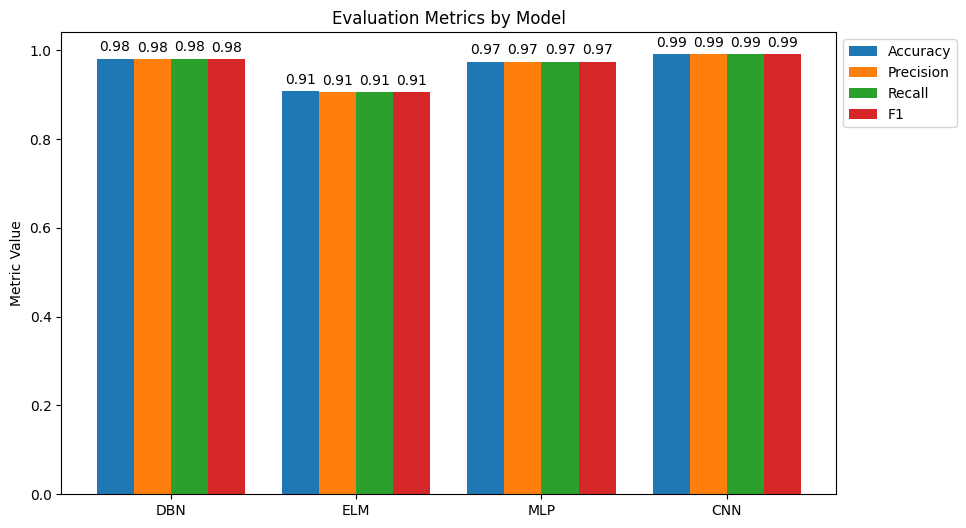

In [37]:
def plot_metrics(metrics):
    """
    Plot the evaluation metrics for each model in a grouped bar plot.
    """
    model_names = list(metrics.keys())
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
    n_models = len(model_names)
    n_metrics = len(metric_names)

    # Build data matrix: rows are models, columns are metrics
    data = np.zeros((n_models, n_metrics))
    for i, model in enumerate(model_names):
        for j, metric in enumerate(metric_names):
            data[i, j] = metrics[model][metric]

    x = np.arange(n_models)
    width = 0.2
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(n_metrics):
        rects = ax.bar(
            x + i * width - (n_metrics / 2) * width + width / 2,
            data[:, i],
            width,
            label=metric_names[i]
        )
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                ax.annotate(
                    f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center',
                    va='bottom'
                )
    ax.set_ylabel('Metric Value')
    ax.set_title('Evaluation Metrics by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

plot_metrics(metrics)